In [0]:
import os
if not os.path.exists('./bbc-text.csv'):
  !wget https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

In [6]:
import os
for dirname, _, filenames in os.walk('./'):
  for filename in filenames:
    if 'bbc' in filename:
      print(os.path.join(dirname, filename))

./bbc-text.csv


In [70]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

import sklearn

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# read the dataframe

df = pd.read_csv('./bbc-text.csv', engine='c')

print('dataset shape', df.shape)
print(df.sample(10))

print('\nNumber of categories\n', df.category.value_counts())

dataset shape (2225, 2)
           category                                               text
1128          sport  capriati to miss melbourne jennifer capriati h...
1606          sport  edu describes tunnel fracas arsenal s edu has ...
1810       business  yukos unit fetches $9bn at auction a little-kn...
1939          sport  england claim dubai sevens glory england beat ...
685        business  iraq and afghanistan in wto talks the world tr...
222           sport  gardener battles to narrow win jason gardener ...
1457          sport  iranian misses israel match iranian striker va...
570   entertainment  us actor  found with gun residue  actor robert...
1378  entertainment  singer christina aguilera to wed pop star chri...
377        politics  top tories on lib dem  hit list  the liberal d...

Number of categories
 sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


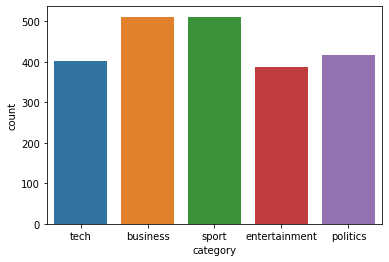

In [14]:
sns.countplot(df['category'])

Data cleansing

In [55]:
print('Data cleansing in progress.......')

# keep only words and remove punctuations and special characters
regex = re.compile('[A-za-z]{2,}')
df['clean_text'] = df['text'].apply(lambda text: regex.findall(text.lower()))
# join the text back
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([item for item in x]))

# tokenize using 'nltk.word_tokenize'
df['clean_text']  = df['clean_text'].apply(nltk.word_tokenize)
print('tokenization complete.........')

# remove stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: [item for item in x if item not in stop_words])
print('removed stop words..........')

# Lemmatization
lem = nltk.stem.WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: [lem.lemmatize(w, pos='v') for w in x])

print('Lemmatization complete. Data cleaning complete')
df['clean_text']

Data cleansing in progress.......
tokenization complete.........
removed stop words..........
Lemmatization complete. Data cleaning complete


0       [tv, future, hand, viewers, home, theatre, sys...
1       [worldcom, boss, leave, book, alone, former, w...
2       [tigers, wary, farrell, gamble, leicester, say...
3       [yeading, face, newcastle, fa, cup, premiershi...
4       [ocean, twelve, raid, box, office, ocean, twel...
                              ...                        
2220    [cars, pull, us, retail, figure, us, retail, s...
2221    [kilroy, unveil, immigration, policy, ex, chat...
2222    [rem, announce, new, glasgow, concert, us, ban...
2223    [political, squabble, snowball, become, common...
2224    [souness, delight, euro, progress, boss, graem...
Name: clean_text, Length: 2225, dtype: object

Classification using a `word2vec`
Create embedding for the tokens using `word2vec` model
The trained word vectors are stored in a `KeyedVectors` instance in `model.wv` as per [document](https://radimrehurek.com/gensim/models/word2vec.html)
> vector = model.wv['computer']  # numpy vector of a word

> `wv.index2word`: contain the word tokens

> `wv.syn0` hold the raw vector representation as per [link](https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm)

In [0]:
from gensim.models import Word2Vec

In [69]:
vec_model = Word2Vec(df['clean_text'])

# combine the tokens with their vector representaions

w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

# randomly sample from the dictionary
import random
random.sample(w2v.items(), 3)

[('charvis',
  array([-6.35777488e-02, -3.82974111e-02, -4.10571042e-03, -2.70215608e-02,
          2.60622855e-02,  1.03679456e-01, -1.03018165e-01,  1.16622131e-02,
         -3.14209908e-02,  1.83630157e-02, -2.08866373e-02,  7.50203133e-02,
         -6.58371137e-04, -7.08387047e-02,  6.55803904e-02,  1.71736646e-02,
          3.03957649e-02, -3.75988707e-02, -2.04417296e-02, -1.20868618e-02,
          8.04764777e-03, -9.82072800e-02, -3.59310731e-02,  2.53179651e-02,
         -1.17174089e-02, -3.08029130e-02,  4.91798297e-03, -1.30077541e-01,
         -8.87581259e-02,  1.88616067e-02,  4.01199833e-02, -1.11953892e-01,
         -4.66816273e-04, -6.78891968e-03, -8.07297304e-02,  5.79738244e-02,
          6.56713471e-02,  2.06460804e-03,  5.53929713e-03, -4.97841351e-02,
         -5.14394045e-02,  1.17916828e-02,  4.00030054e-02,  1.05050407e-01,
         -8.63436908e-02,  1.25413805e-01,  4.87769581e-02, -5.89469122e-03,
         -3.64966281e-02, -2.07839683e-02,  5.49481809e-02,  5.

In [102]:
len(w2v.keys())

8604

In [0]:
# classification models

# import models
# from sklearn.naive_bayes import GaussianNB
# from 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV

clf_models = {
      'Naive Bayes': GaussianNB(),
      'SVC': sklearn.svm.SVC(),
      'Decision Tree': DecisionTreeClassifier(),
      'Perceptron': MLPClassifier(),
      'GradientBoosting': GradientBoostingClassifier()
}

clf_params = {
      'Naive Bayes': {},
      'SVC': {'kernel': ['linear', 'rbf']},
      'Decision Tree': {'min_samples_split': [2, 5], 'max_depth': [10, 15]},
      'Perceptron': {'activation': ['relu', 'tanh', 'sigmoid']},
      'GradientBoosting': {'min_samples_split': [2, 5], 'max_depth': [10, 15]}
}

# need to create class with a fit/transform method as the 'word2vec' model has no fit/transform method

class Vectorizer(object):

    def __init__(self, vec):
        self.vec = vec,
        self.dim = len(vec.keys())

    def fit(self, X, y):
        return self # no action required

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


# creating a class for Classifer as not every model has a fit/transform methods

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        # grid search
        self.gs = GridSearchCV(self.model, self.param, cv=5, refit=True)
      
    def fit(self, X, y):
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

# def grid_search(model, param):
#     return GridSearchCV(model, param, cv=5)

# train , test splits
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

# from sklearn.pipeline import Pipeline, make_pipeline

# for key in clf_models.keys():
#     #pipeline  = make_pipeline(Vectorizer(w2v), Classifier(clf_models[key], clf_params[key]))
#     pipeline = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     print(key, ':' )
#     print('Accuracy: {:.2f} \t Precision: {:.2f} \t Recall: {:.2f} \t F1: {:.2f}'.format(
#         sklearn.metrics.accuracy_score(y_pred, y_test),
#         sklearn.metrics.precision_score(y_pred, y_test, average='macro'),
#         sklearn.metrics.recall_score(y_pred, y_test , average='macro'),
#         sklearn.metrics.f1_score(y_pred, y_test, average='macro')
#     ))

In [135]:
# using TF-IDF vectorizer
def Vectorize(vec, X_train, X_test):
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)

    print("Vectorization complet .............")
    return X_train_vec, X_test_vec

# use multiple classifiers with GridSearch

def ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test):

    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some arguments missing')
    
    for key in models.keys():
        model = models[key]
        param = params[key]

        # use GridSearchCV on the model and range of hyperparameters
        gs = GridSearchCV(model, param, cv=5, refit=True)
        gs.fit(X_train_vec, y_train)
        y_pred = gs.predict(X_test_vec)

        # find the best parameters of the model
        print(key, ':', gs.best_params_)

        print('Accuracy: {:.2f} \t Precision: {:.2f} \t Recall: {:.2f} \t F1: {:.2f}'\
              .format(
                  sklearn.metrics.accuracy_score(y_pred, y_test),
                  sklearn.metrics.precision_score(y_pred, y_test, average='macro'),
                  sklearn.metrics.recall_score(y_pred, y_test , average='macro'),
                  sklearn.metrics.f1_score(y_pred, y_test, average='macro')
              ))

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}

# use label encoder to encode the 'categories'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
labels = list(le.classes_)


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

# Vectorize using TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complet .............
Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.97 	 Precision: 0.97 	 Recall: 0.97 	 F1: 0.97
Decision Tree : {'min_samples_split': 2}
Accuracy: 0.78 	 Precision: 0.78 	 Recall: 0.78 	 F1: 0.78
Perceptron : {'activation': 'relu', 'alpha': 0.0001}
Accuracy: 0.98 	 Precision: 0.98 	 Recall: 0.98 	 F1: 0.98
Gradient Boosting : {'learning_rate': 0.1, 'min_samples_split': 5}
Accuracy: 0.95 	 Precision: 0.95 	 Recall: 0.96 	 F1: 0.95


True